In [1]:
import glob
import regex as re
import numpy as np
import pandas as pd
import xgboost as xgb
import tensorflow as tf
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline
%run ../airquality/data/gen_daily_targets.py

In [2]:
with open('../data/headers_mod.csv') as f:
    mod_headers = f.readlines()[0].split()
    
with open('../data/headers_obs.csv') as f:
    obs_headers = f.readlines()[0].split()
    
mod_headers, obs_headers

(['lon', 'lat', 'day', 'hour', 'AirPollutant', 'Concentration'],
 ['Countrycode',
  'Namespace',
  'AirQualityNetwork',
  'AirQualityStation',
  'AirQualityStationEoICode',
  'SamplingPoint',
  'SamplingProcess',
  'Sample',
  'AirPollutant',
  'AirPollutantCode',
  'AveragingTime',
  'Concentration',
  'UnitOfMeasurement',
  'DatetimeBegin',
  'DatetimeEnd',
  'Validity',
  'Verification'])

In [3]:
test = pd.read_csv('../data/targets.csv')
stations = pd.read_csv('../data/stations.csv')

In [7]:
observations = []
for folder in glob.glob('../data/obs/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[1])
        data = pd.read_csv(file, sep='\t', names=obs_headers)
        data['year'] = year
        data['station'] = station
        observations.append(data)
        
observations = pd.concat(observations)
observations = observations[[c for c in observations.columns if c not in [
    'Countrycode',
    'Namespace',
    'AirQualityNetwork',
    'AirQualityStation',
    'AirQualityStationEoICode',
    'SamplingPoint',
    'SamplingProcess',
    'AveragingTime',
    'UnitOfMeasurement',
    'AirPollutant',
    'AirPollutantCode',
    'Validity',
    'Verification',
    'DatetimeEnd',
    'Sample'
]]]
observations['datetime'] = pd.to_datetime(observations['DatetimeBegin'])
observations = observations.drop('DatetimeBegin', axis=1)
observations = observations.sort_values('datetime')
observations['day'] = observations['datetime'].apply(lambda dt: dt.date())
observations['time'] = observations['datetime'].apply(lambda dt: dt.time())
observations = pd.merge(observations, gen_daily_targets(observations)[['station', 'day', 'target']],
                        how='left', on=['station', 'day'])
observations.to_csv('../data/observations.csv')
observations.head(5)

,Concentration,year,station,datetime,day,time,target
0,51,2013,ES1438A,2013-01-01 01:00:00,2013-01-01,01:00:00,1
1,39,2013,ES1396A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
2,48,2013,ES1679A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
3,11,2013,ES1856A,2013-01-01 01:00:00,2013-01-01,01:00:00,0
4,55,2013,ES0691A,2013-01-01 01:00:00,2013-01-01,01:00:00,0


In [8]:
observations.groupby(['year', 'station']).agg({
    'Concentration': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'datetime': ['min', 'max'],
    'target': ['sum']
})

target            datetime                     Concentration  \
                sum                 min                 max          mean   
year station                                                                
2013 ES0691A    777 2013-01-01 01:00:00 2013-12-31 23:00:00         40.01   
     ES1396A   1070 2013-01-01 01:00:00 2013-12-31 23:00:00         33.65   
     ES1438A   3830 2013-01-01 01:00:00 2013-12-31 23:00:00         56.73   
     ES1480A   3287 2013-01-01 01:00:00 2013-12-31 23:00:00         54.59   
     ES1679A    622 2013-01-01 01:00:00 2013-12-31 23:00:00         35.37   
     ES1856A   1026 2013-01-01 01:00:00 2013-12-31 23:00:00         27.50   
     ES1992A   1933 2013-01-01 01:00:00 2013-12-31 23:00:00         32.66   
2014 ES0691A    592 2013-12-31 23:00:00 2014-12-31 23:00:00         39.35   
     ES1396A    498 2013-12-31 23:00:00 2014-12-31 23:00:00         32.15   
     ES1438A   2443 2013-12-31 23:00:00 2014-12-31 23:00:00         52.35   
     ES1480A   2642 2013-12-31 23:00:00 2014-12-31 23:00:00         51.82   
     ES1679A    681 2013-12-31 23:00:00 2014-12-31 23:00:00         37.24   
     ES1856A    877 2013-12-31 23:00:00 2014-12-31 23:00:00         28.48   
     ES1992A   1508 2013-12-31 23:00:00 2014-12-31 23:00:00         31.22   
2015 ES0691A   1249 2014-12-31 23:00:00 2015-12-31 23:00:00         45.16   
     ES1396A    733 2014-12-31 23:00:00 2015-12-31 23:00:00         36.41   
     ES1438A   1980 2014-12-31 23:00:00 2015-12-31 23:00:00         56.97   
     ES1480A   2111 2014-12-31 23:00:00 2015-12-31 23:00:00         54.87   
     ES1679A   1167 2014-12-31 23:00:00 2015-12-31 23:00:00         42.39   
     ES1856A    945 2014-12-31 23:00:00 2015-12-31 23:00:00         32.21   
     ES1992A   1140 2014-12-31 23:00:00 2015-12-31 23:00:00         34.78   

                                          
               std    var count min  max  
year station                              
2013 ES0691A 22.48 505.51  8643   1  135  
     ES1396A 22.04 485.90  8627   1  163  
     ES1438A 27.00 729.02  8420   1  253  
     ES1480A 27.63 763.52  8656   1  229  
     ES1679A 23.34 544.71  8625   1  183  
     ES1856A 21.46 460.52  8496   1  147  
     ES1992A 24.13 582.27  8617   1  183  
2014 ES0691A 22.70 515.25  8585   3  141  
     ES1396A 20.56 422.81  8592   3  158  
     ES1438A 23.83 567.98  8562   7  170  
     ES1480A 26.64 709.55  8592   3  202  
     ES1679A 22.99 528.56  8660   1  132  
     ES1856A 21.64 468.16  8613   1  157  
     ES1992A 23.86 569.22  8597   1  189  
2015 ES0691A 24.79 614.64  5691   4  166  
     ES1396A 23.21 538.53  5469   1  172  
     ES1438A 25.08 629.03  5617   8  178  
     ES1480A 27.93 780.25  5554   1  217  
     ES1679A 24.76 612.95  5745   1  172  
     ES1856A 23.76 564.38  5750   1  169  
     ES1992A 24.80 614.96  5622   1  195

In [9]:
models = []
for folder in glob.glob('../data/mod/*'):
    for file in glob.glob('{}/*'.format(folder)):
        year = re.search('\d{4}', file)[0]
        station = 'ES{}A'.format(re.findall('\d{4}', file)[-1])
        data = pd.read_table(file, sep='\s+', names=mod_headers)
        data['days_ahead'] = (data['day'] == data['day'].max()).astype(int)
        days_ahead = data.pivot(index='hour', columns='days_ahead', values='Concentration').reset_index()
        days_ahead['day'] = data.day.min()
        data = pd.merge(days_ahead, data[['lon', 'lat', 'hour']],
                        on='hour', how='left')\
            .rename(columns={0: 'pred_0_days', 1: 'pred_1_days'})\
            .drop_duplicates()
        data['year'] = year
        data['station'] = station
        models.append(data)
        
models = pd.concat(models)
models['datetime'] = pd.to_datetime(models['day'].astype(str) + ' ' + models['hour'].astype(str))
models = models.sort_values('datetime', ascending=True)
models['day'] = models['datetime'].apply(lambda dt: dt.date())
models['time'] = models['datetime'].apply(lambda dt: dt.time())
models = models[[c for c in models.columns if c not in [
    'AirPollutant',
    'hour'
]]].sort_values('datetime')
models.to_csv('../data/models.csv')
models.head(5)

,pred_0_days,pred_1_days,day,lon,lat,year,station,datetime,time
0,31.81,31.59,2013-01-01,2.15,41.43,2013,ES1856A,2013-01-01,00:00:00
0,28.53,27.48,2013-01-01,2.12,41.39,2013,ES1992A,2013-01-01,00:00:00
0,28.53,27.48,2013-01-01,2.13,41.38,2013,ES1396A,2013-01-01,00:00:00
0,35.85,42.57,2013-01-01,2.20,41.40,2013,ES0691A,2013-01-01,00:00:00
0,38.79,34.11,2013-01-01,2.15,41.39,2013,ES1438A,2013-01-01,00:00:00


In [10]:
models.groupby(['year', 'station']).agg({
    'pred_0_days': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'pred_1_days': ['mean', 'std', 'var', 'count', 'min', 'max'],
    'datetime': ['min', 'max']
})

datetime                     pred_0_days                     \
                    min                 max        mean   std    var count   
year station                                                                 
2013 ES0691A 2013-01-01 2013-12-31 23:00:00       40.05 28.29 800.10  8760   
     ES1396A 2013-01-01 2013-12-31 23:00:00       35.26 23.39 547.19  8760   
     ES1438A 2013-01-01 2013-12-31 23:00:00       49.35 29.49 869.59  8760   
     ES1480A 2013-01-01 2013-12-31 23:00:00       38.59 26.10 681.37  8760   
     ES1679A 2013-01-01 2013-12-31 23:00:00       49.35 29.49 869.59  8760   
     ES1856A 2013-01-01 2013-12-31 23:00:00       38.59 26.10 681.37  8760   
     ES1992A 2013-01-01 2013-12-31 23:00:00       35.26 23.39 547.19  8760   
2014 ES0691A 2014-01-01 2014-12-31 23:00:00       41.69 30.56 933.68  8760   
     ES1396A 2014-01-01 2014-12-31 23:00:00       36.01 23.77 565.03  8760   
     ES1438A 2014-01-01 2014-12-31 23:00:00       52.75 31.47 990.29  8760   
     ES1480A 2014-01-01 2014-12-31 23:00:00       40.40 27.23 741.38  8760   
     ES1679A 2014-01-01 2014-12-31 23:00:00       52.75 31.47 990.29  8760   
     ES1856A 2014-01-01 2014-12-31 23:00:00       40.40 27.23 741.38  8760   
     ES1992A 2014-01-01 2014-12-31 23:00:00       36.01 23.77 565.03  8760   
2015 ES0691A 2015-01-01 2015-12-31 23:00:00       38.40 30.05 903.02  8664   
     ES1396A 2015-01-01 2015-12-31 23:00:00       36.81 25.51 650.98  8664   
     ES1438A 2015-01-01 2015-12-31 23:00:00       48.63 30.55 933.05  8664   
     ES1480A 2015-01-01 2015-12-31 23:00:00       41.10 29.64 878.63  8664   
     ES1679A 2015-01-01 2015-12-31 23:00:00       48.63 30.55 933.05  8664   
     ES1856A 2015-01-01 2015-12-31 23:00:00       41.10 29.64 878.63  8664   
     ES1992A 2015-01-01 2015-12-31 23:00:00       36.81 25.51 650.98  8664   

                         pred_1_days                                 
              min    max        mean   std    var count  min    max  
year station                                                         
2013 ES0691A 0.73 168.19       39.14 28.03 785.56  8759 1.14 164.75  
     ES1396A 3.93 181.36       34.51 22.81 520.29  8759 3.52 167.75  
     ES1438A 3.05 197.72       48.31 28.67 822.08  8759 2.12 195.16  
     ES1480A 2.82 159.23       37.50 25.37 643.64  8759 3.04 174.96  
     ES1679A 3.05 197.72       48.31 28.67 822.08  8759 2.12 195.16  
     ES1856A 2.82 159.23       37.50 25.37 643.64  8759 3.04 174.96  
     ES1992A 3.93 181.36       34.51 22.81 520.29  8759 3.52 167.75  
2014 ES0691A 1.43 189.77       40.11 30.48 928.95  8759 1.19 188.68  
     ES1396A 3.99 166.05       35.26 23.02 529.72  8759 4.43 171.68  
     ES1438A 4.03 225.09       51.04 30.55 933.51  8759 3.95 239.08  
     ES1480A 3.14 175.37       39.46 26.89 722.99  8759 3.98 183.37  
     ES1679A 4.03 225.09       51.04 30.55 933.51  8759 3.95 239.08  
     ES1856A 3.14 175.37       39.46 26.89 722.99  8759 3.98 183.37  
     ES1992A 3.99 166.05       35.26 23.02 529.72  8759 4.43 171.68  
2015 ES0691A 1.24 152.71       36.34 29.53 871.80  8664 1.09 145.46  
     ES1396A 3.38 179.40       36.33 24.82 616.16  8664 3.70 155.44  
     ES1438A 3.71 182.38       47.26 29.88 893.00  8664 2.86 159.00  
     ES1480A 3.77 194.44       40.29 28.71 824.51  8664 3.20 168.40  
     ES1679A 3.71 182.38       47.26 29.88 893.00  8664 2.86 159.00  
     ES1856A 3.77 194.44       40.29 28.71 824.51  8664 3.20 168.40  
     ES1992A 3.38 179.40       36.33 24.82 616.16  8664 3.70 155.44

In [11]:
observations.shape

(159733, 7)

In [12]:
observations.drop_duplicates(['datetime', 'station']).shape

(159719, 7)

In [13]:
models.shape

(183960, 9)

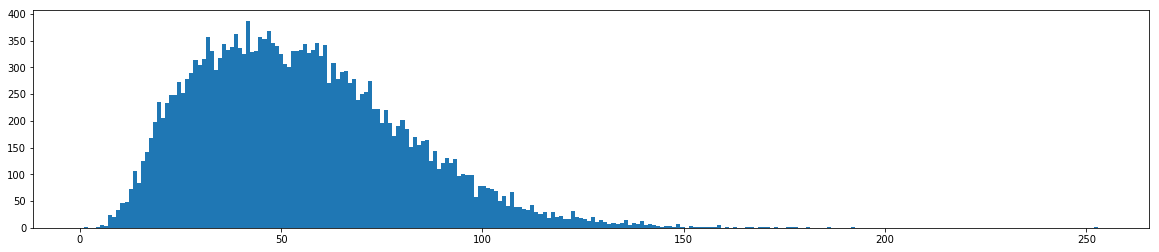

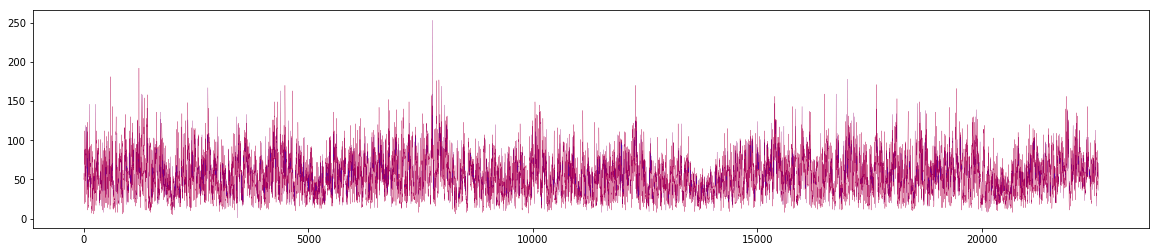

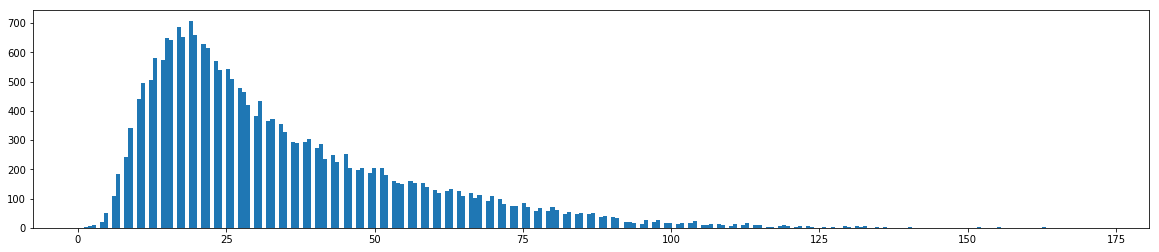

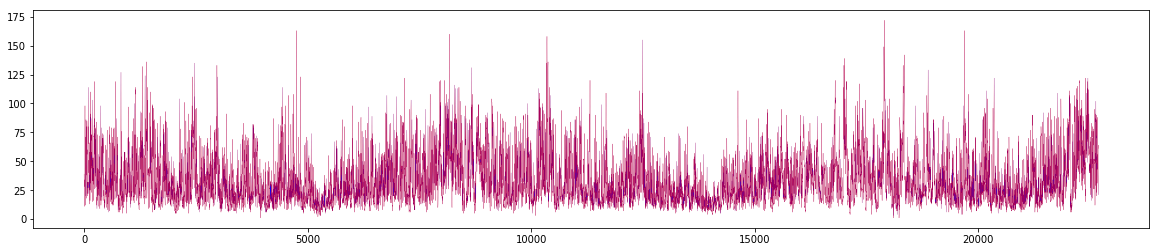

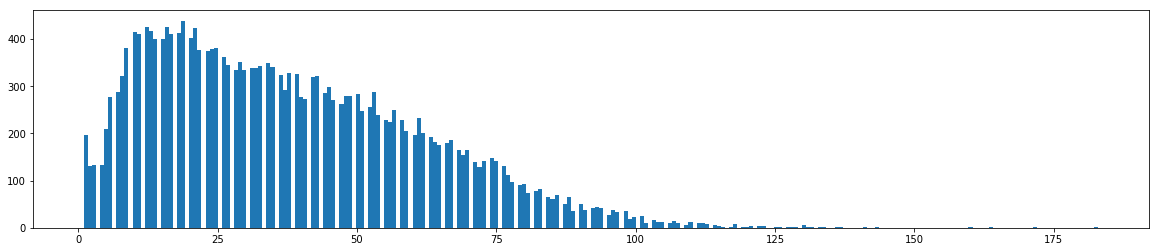

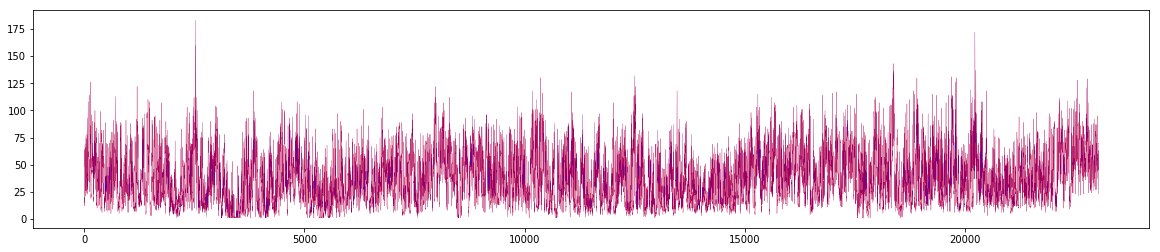

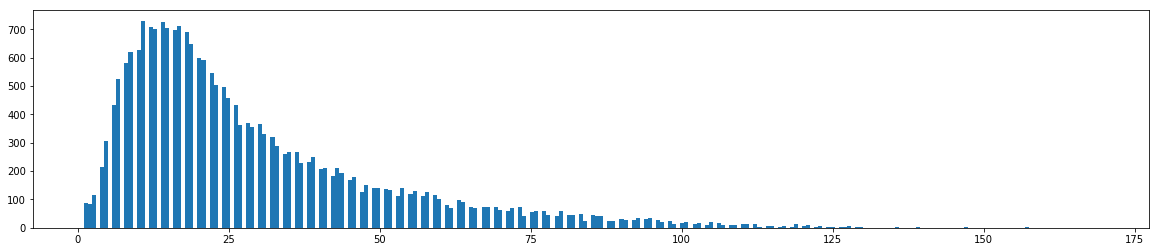

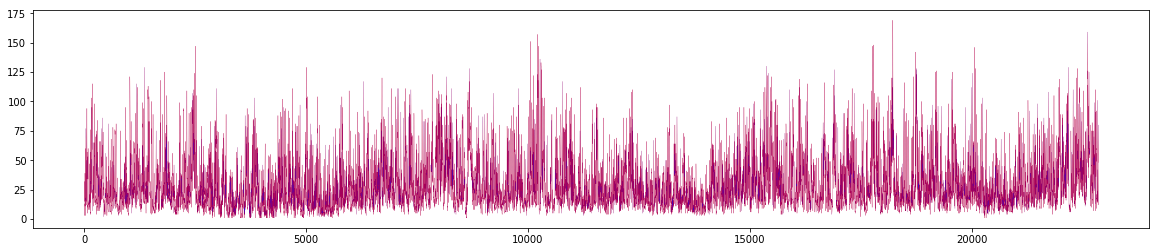

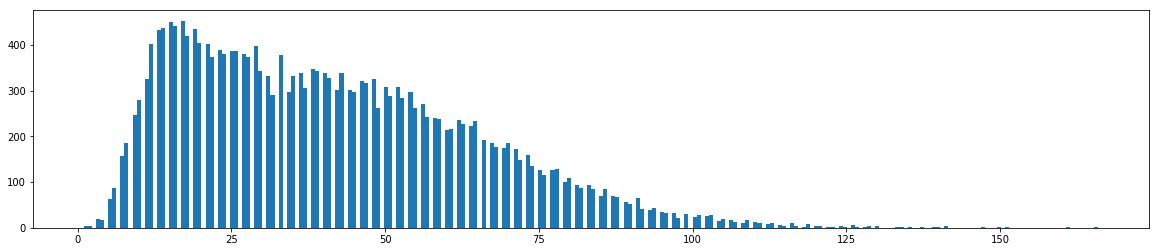

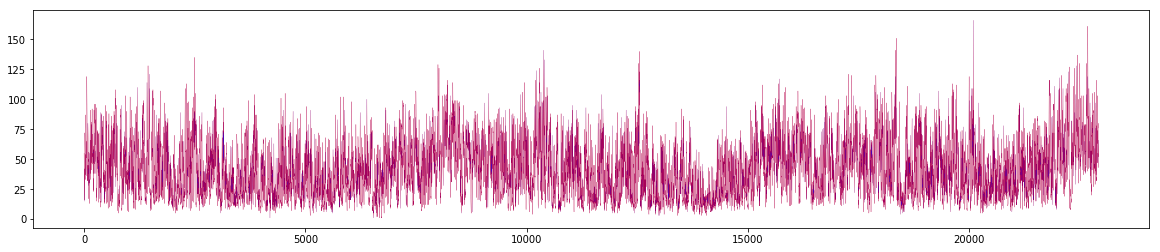

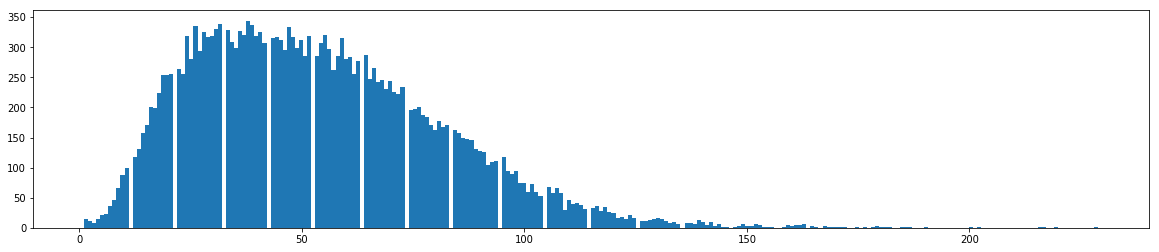

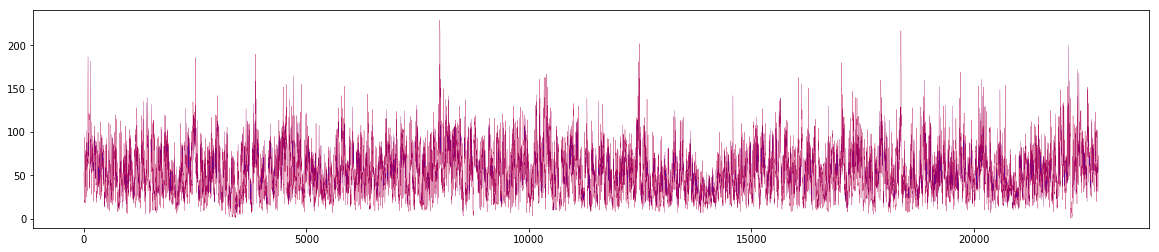

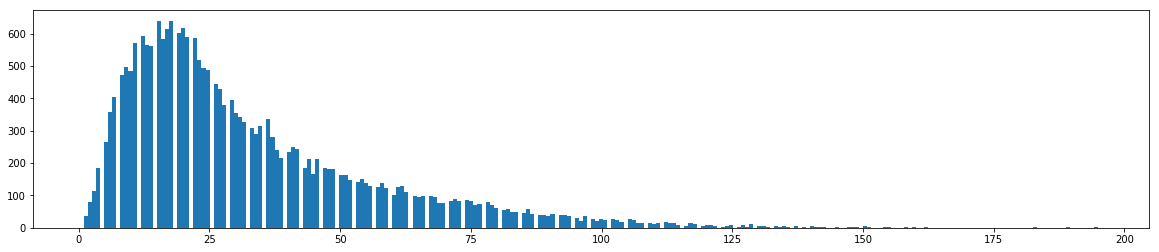

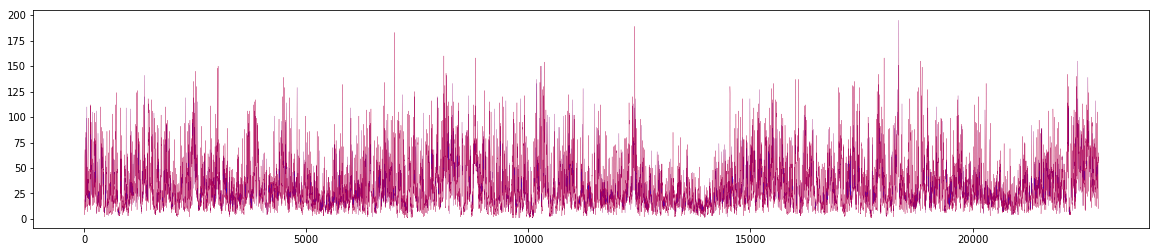

In [14]:
for s in observations['station'].unique():
    plt.figure(figsize=(20, 4))
    plt.hist(observations[observations['station'] == s]['Concentration'], bins=250)
    plt.figure(figsize=(20, 4))
    x_ax = list(range(0, observations[observations['station'] == s].shape[0]))
    plt.plot(x_ax, observations[observations['station'] == s]['Concentration'], 'r-', lw=.2)
    plt.plot(x_ax, observations[observations['station'] == s]['Concentration'], 'b--', lw=.1)

In [15]:
1

1